# Reading Data

In [1]:
import numpy as np
import pandas as pd

In [108]:
def load_dataset(file_path = "train_FD002.txt"):
    data = np.loadtxt(file_path) # read the data set
    
    #prepare column names
    sensor_col_name = ["Sensor "+str(i) for i in range(1,22)]
    col_name = ["unit number", "time-cycles", "operational setting 1", "operational setting 2",
            "operational setting 3"] + sensor_col_name
    
    df = pd.DataFrame(data= data, columns= col_name) # convert to dataframe
    
    df["unit number"] = df["unit number"].apply(lambda x: int(x)) # adjust the column type
    
    # prepare RUL column
    total_units = int(df["unit number"].max())
    RUL_list = pd.Series(dtype="int64")
    for unit_i in range(1, total_units+1):

        df_subset = df[df["unit number"] == unit_i ]
        max_cycle = max(df_subset["time-cycles"])

        temp =  max_cycle - df_subset["time-cycles"]
        RUL_list = RUL_list.append(temp)
        
    df["RUL"] = RUL_list
    
    
    # Converting the column to the corect data type
    df["unit number"] = df["unit number"].apply(lambda x: int(x))
    df["time-cycles"] = df["time-cycles"].apply(lambda x: int(x))
    df["operational setting 3"] = df["operational setting 3"].apply(lambda x: int(x))
    df["RUL"] = df["RUL"].apply(lambda x: int(x))
    
    return df

In [109]:
df = load_dataset()

# Preparing the operational conditions

In [140]:
df.columns

Index(['unit number', 'time-cycles', 'operational setting 1',
       'operational setting 2', 'operational setting 3', 'Sensor 1',
       'Sensor 2', 'Sensor 3', 'Sensor 4', 'Sensor 5', 'Sensor 6', 'Sensor 7',
       'Sensor 8', 'Sensor 9', 'Sensor 10', 'Sensor 11', 'Sensor 12',
       'Sensor 13', 'Sensor 14', 'Sensor 15', 'Sensor 16', 'Sensor 17',
       'Sensor 18', 'Sensor 19', 'Sensor 20', 'Sensor 21', 'RUL'],
      dtype='object')

In [141]:
features_list = ['operational setting 1', 'operational setting 2',
        'operational setting 3',
        'Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4', 'Sensor 5',
        'Sensor 6', 'Sensor 7', 'Sensor 8', 'Sensor 9', 'Sensor 10',
        'Sensor 11', 'Sensor 12', 'Sensor 13', 'Sensor 14', 'Sensor 15',
        'Sensor 16', 'Sensor 17', 'Sensor 18', 'Sensor 19', 'Sensor 20', 'Sensor 21']

In [142]:
X = df[features_list]
X = pd.get_dummies(X, columns=['operational setting 3'])

y = df["RUL"]

In [143]:
print("X shape : {}, y shape: {}".format(X.shape, y.shape))

X shape : (53759, 25), y shape: (53759,)


## Test Train split

In [144]:
from sklearn.model_selection import train_test_split

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Scale the data

In [146]:
from sklearn.preprocessing import StandardScaler

In [147]:
scaler = StandardScaler()

In [148]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ML models

In [149]:
def ML_regress(estimator, X_train, y_train,
              X_test, y_test):
    
    
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    
    accuracy = mean_absolute_error(y_test, y_pred)
    
    print("accuracy = {:.4f}".format(accuracy))
    return estimator , accuracy

## Random forest

In [150]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [151]:
rfr, frf_MAE = ML_regress(RandomForestRegressor(random_state=42),
                          X_train, y_train, X_test, y_test)

accuracy = 31.5930


In [152]:
results = dict()
results["MAE RFR"] = frf_MAE

In [153]:
import matplotlib.pyplot as plt

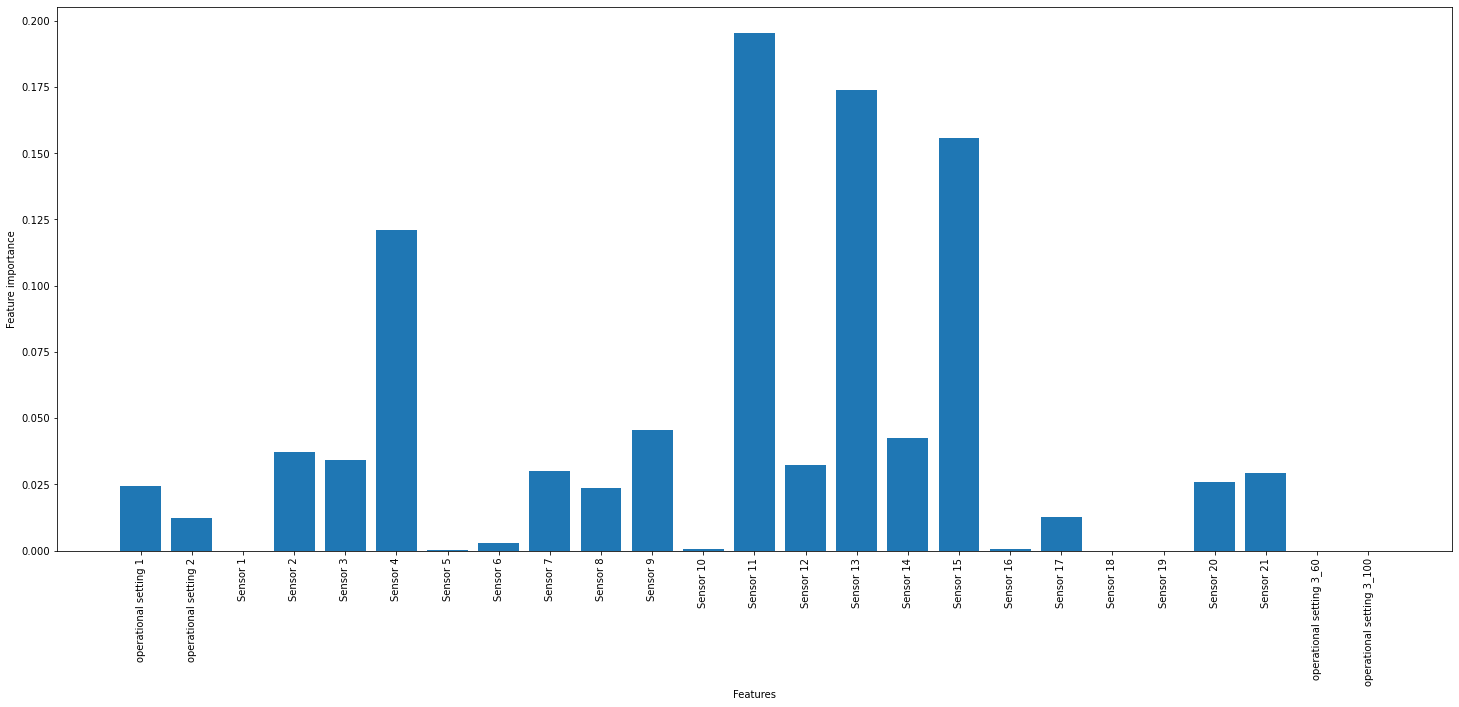

In [154]:
features_importance = rfr.feature_importances_
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(111)
ax.bar(x= X.columns ,height= features_importance)
plt.ylabel("Feature importance")
plt.xlabel("Features")
plt.xticks(rotation=90) 
plt.savefig("Feature_imporance.png")
plt.show()

# SVR

# LASSO

In [157]:
from sklearn.linear_model import Lasso

In [158]:
lasso, lasso_MAE = ML_regress(Lasso(),
                          X_train, y_train, X_test, y_test)

accuracy = 43.8853


In [159]:
results["MAE LASSO"] = lasso_MAE

In [160]:
pd.Series(lasso.coef_, index=X.columns)[abs(pd.Series(lasso.coef_, index=X.columns)) > 0]

Sensor 1      52.476478
Sensor 4     -21.194922
Sensor 11   -152.492277
Sensor 14    -40.993264
Sensor 15   -191.516533
Sensor 16    -20.620721
dtype: float64

In [164]:
new_features = pd.Series(lasso.coef_, index=X.columns)[abs(pd.Series(lasso.coef_, index=X.columns)) > 0].index

# Results

In [161]:
pd.DataFrame(results ,index=['Mean absolute error [RUL]']).T

,Mean absolute error [RUL]
MAE RFR,31.592978
MAE LASSO,43.885320


# Dropping LASSO irrelevant features.

In [166]:
X_reduced = X[new_features]
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced, y, test_size=0.33, random_state=42)

## RFrm

In [167]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [168]:
rfr, frf_MAE = ML_regress(RandomForestRegressor(random_state=42),
                          X_train_reduced, y_train, X_test_reduced, y_test)

accuracy = 33.8483


In [169]:
results_reduced = dict()
results_reduced["MAE RFR"] = frf_MAE

In [170]:
import matplotlib.pyplot as plt

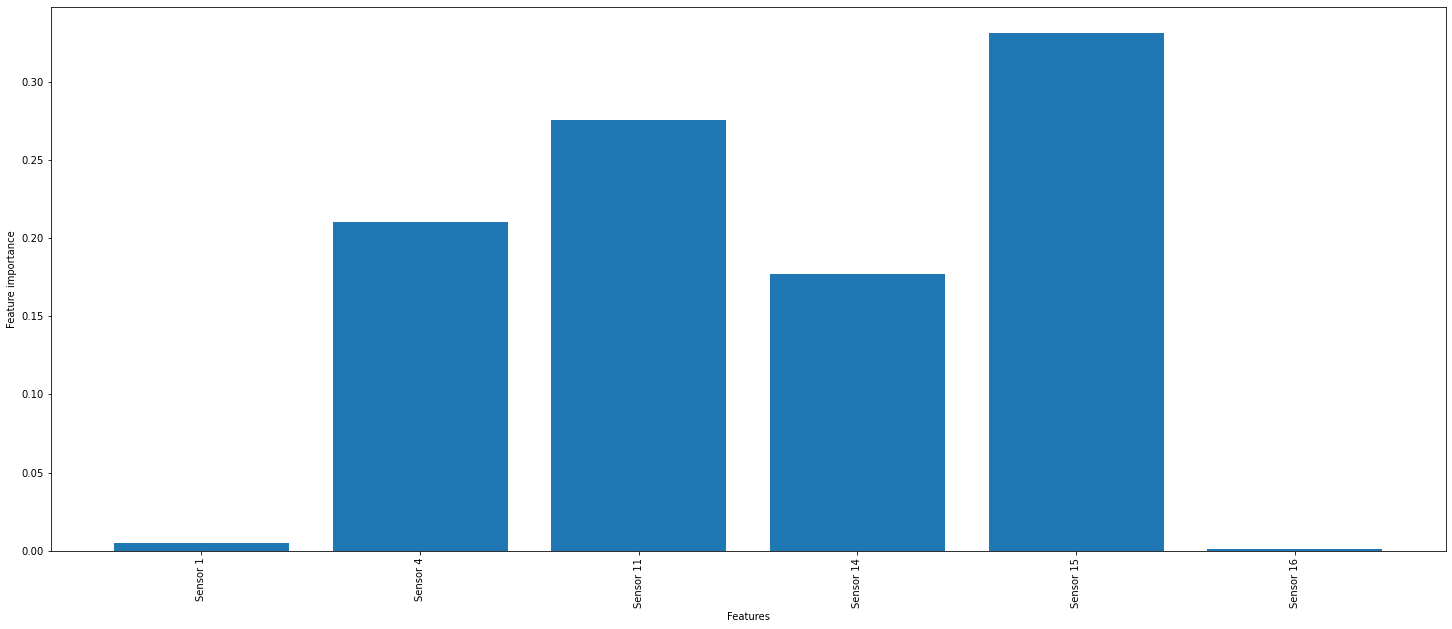

In [172]:
features_importance = rfr.feature_importances_
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(111)
ax.bar(x= X_reduced.columns ,height= features_importance)
plt.ylabel("Feature importance")
plt.xlabel("Features")
plt.xticks(rotation=90) 
plt.savefig("Feature_imporance.png")
plt.show()

# Model Validation

In [192]:
def model_val(y_true, y_pred):
    error = y_true - y_pred
    
    plt.style.use("ggplot")
    plt.figure(figsize=(14,5))
    plt.hist(error, bins=25)
    plt.xlabel('Prediction Error [RUL]')
    _ = plt.ylabel('Count')
    plt.show()
    
    plt.figure(figsize=(14,5))
    plt.scatter(y_pred, error)
    plt.xlabel("y_pred")
    plt.ylabel("Error")
    plt.show()
    
    print("Error mean = {:.2f}, Error STD = {:.2f}".format(error.mean(), error.std()))

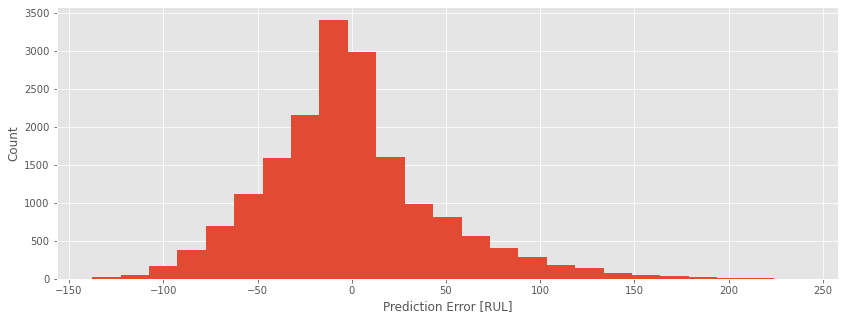

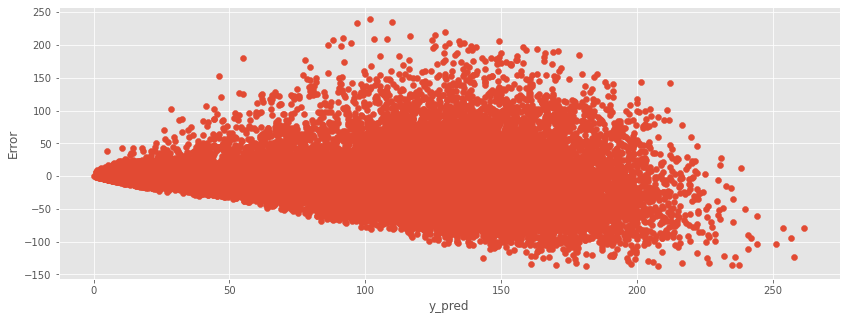

Error mean = -1.21, Error STD = 46.15


In [193]:
model_val(y_test, rfr.predict(X_test_reduced))

# Final notebook results

The feature importance method from random forest and the coef.s From the lasso regression indicates that non of the operational conditions are important. Also, very few sensor carries information. 

Testing on the subset of the important data-set only showed increase of 3-points in the MAE. The increase of the points is non-significant.

### Side work

In [195]:
from sklearn.linear_model import LinearRegression

In [196]:
lr, lr_MAE = ML_regress(LinearRegression(),
                          X_train_reduced, y_train, X_test_reduced, y_test)

accuracy = 38.6788


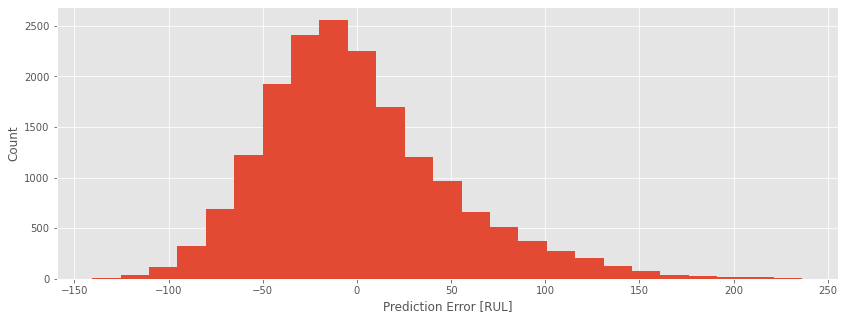

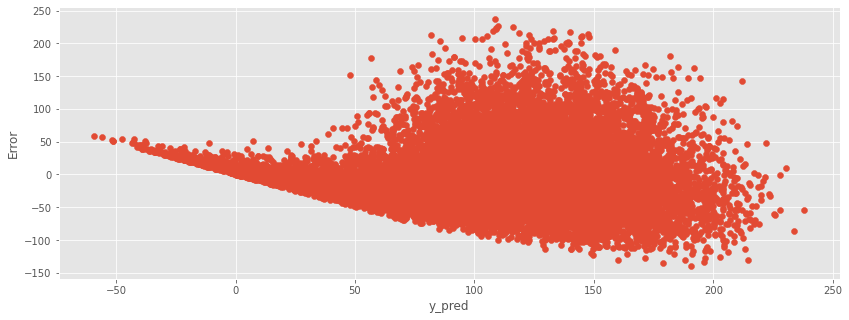

Error mean = -0.16, Error STD = 50.28


In [197]:
model_val(y_test, lr.predict(X_test_reduced))